In [1]:
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   # Delete if you have GPU's available
import tensorflow_datasets as tfds
import tensorflow as tf


In [2]:

import tensorflow_datasets as tfds
import tensorflow as tf

# Convert sample function with normalization
def convert_sample(sample):
    image, label = sample['image'], sample['label']  
    image = tf.image.convert_image_dtype(image, tf.float32)  # Converts to float32 and scales to [0, 1]
    return image, image  # Use the image itself as the target label





In [3]:
import tensorflow_datasets as tfds

# Corrected file path with escaped backslashes and a missing comma
ds1, ds2, ds3 = tfds.load('patch_camelyon',
                         split=['train[:10%]', 'test[:2.5%]', 'validation[:2.5%]'],
                         data_dir=r'C:\Users\jeppe\OneDrive\Dokumenter\Privat\SDU\DataScience\Anvendtmaskinlæring\eksamen',
                         download=False,
                         shuffle_files=True)


In [4]:
train_dataset       = ds1.map(convert_sample).batch(32)
validation_dataset  = ds3.map(convert_sample).batch(32)
test_dataset        = ds2.map(convert_sample).batch(32)



In [8]:
#nedenstående model er baseline VAE
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): #initialiserer encoderen, definerer lagene og præciserer hvordan vores model skal konstrueres
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): #den faktiske model der forward pass'er data og transformerer det på baggrund af hvad der er defineret i def _init_
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae_base = VAE(latent_dim, original_shape)

# Compile the model
vae_base.compile(optimizer='adam', loss=MeanSquaredError())

# Train the model with callbacks
history = vae_base.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Plot the training and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch 1/10
820/820 [==============================] - 332s 402ms/step - loss: 0.0354 - val_loss: 0.0336
Epoch 2/10
820/820 [==============================] - 311s 379ms/step - loss: 0.0294 - val_loss: 0.0302
Epoch 3/10
820/820 [==============================] - 304s 370ms/step - loss: 0.0274 - val_loss: 0.0298
Epoch 4/10
820/820 [==============================] - 320s 391ms/step - loss: 0.0269 - val_loss: 0.0293
Epoch 5/10
820/820 [==============================] - 306s 373ms/step - loss: 0.0266 - val_loss: 0.0298
Epoch 6/10
820/820 [==============================] - 304s 371ms/step - loss: 0.0264 - val_loss: 0.0294
Epoch 7/10
820/820 [==============================] - 316s 386ms/step - loss: 0.0262 - val_loss: 0.0296
Epoch 8/10
820/820 [==============================] - 323s 393ms/step - loss: 0.0259 - val_loss: 0.0300
Epoch 9/10
820/820 [==============================] - 325s 397ms/step - loss: 0.0256 - val_loss: 0.0301


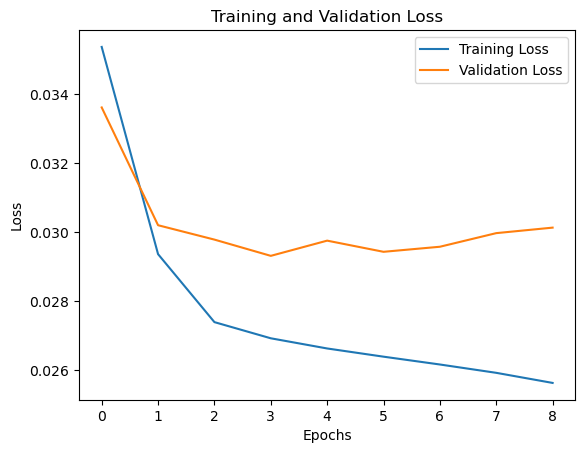

In [10]:
#nedenstående model er VAE med early stopping
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part
class Encoder(tf.keras.layers.Layer): #initialiserer encoderen, definerer lagene og præciserer hvordan vores model skal konstrueres
    def __init__(self, latent_dim): 
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x): #den faktiske model der forward pass'er data og transformerer det på baggrund af hvad der er defineret i def _init_
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae_ES = VAE(latent_dim, original_shape)

# Compile the model
vae_ES.compile(optimizer='adam', loss=MeanSquaredError())

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with callbacks
history = vae_ES.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[early_stopping])

# Plot the training and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
#VAE med weight regulizers
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part with L2 weight regularization
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))
        self.dense_log_var = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part with L2 weight regularization
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu, kernel_regularizer=regularizers.l2(0.01))
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same', kernel_regularizer=regularizers.l2(0.01))

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae_WR = VAE(latent_dim, original_shape)

# Compile the model with L2 weight regularization
vae_WR.compile(optimizer='adam', loss=MeanSquaredError())

# Train the model with callbacks
history = vae_WR.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Plot the training and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError

# Define the encoder part with dropout
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.dropout1 = layers.Dropout(0.2)  # Add dropout layer with 0.2 dropout rate
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.dropout2 = layers.Dropout(0.2)  # Add dropout layer with 0.2 dropout rate
        self.flatten = layers.Flatten()
        self.dense_mean = layers.Dense(latent_dim)
        self.dense_log_var = layers.Dense(latent_dim)

    def call(self, x):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)  # Apply dropout after maxpooling
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)  # Apply dropout after maxpooling
        x = self.flatten(x)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part with dropout
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.dropout3 = layers.Dropout(0.2)  # Add dropout layer with 0.2 dropout rate
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')

    def call(self, z):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        z = self.dropout3(z)  # Apply dropout before the final convolution
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim, original_shape)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x):
        mean, log_var = self.encoder(x)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 128
original_shape = (96, 96, 3)

# Instantiate the VAE
vae_drop = VAE(latent_dim, original_shape)

# Compile the model
vae_drop.compile(optimizer='adam', loss=MeanSquaredError())

# Train the model with callbacks
history = vae_drop.fit(train_dataset, epochs=10, validation_data=validation_dataset)

# Plot the training and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [6]:
#nedenstående model har fået flere regulizers på. alt muligt guf
import tensorflow.compat.v1 as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Define the encoder part
class Encoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, dropout_rate=0.2):
        super(Encoder, self).__init__()
        self.conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.maxpool1 = layers.MaxPooling2D((2, 2), padding='same')
        self.conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.maxpool2 = layers.MaxPooling2D((2, 2), padding='same')
        self.flatten = layers.Flatten()
        self.dropout = layers.Dropout(dropout_rate)
        self.dense_mean = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))
        self.dense_log_var = layers.Dense(latent_dim, kernel_regularizer=regularizers.l2(0.01))

    def call(self, x, training=True):
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.flatten(x)
        x = self.dropout(x, training=training)
        mean = self.dense_mean(x)
        log_var = self.dense_log_var(x)
        return mean, log_var

# Define the decoder part
class Decoder(tf.keras.layers.Layer):
    def __init__(self, latent_dim, original_shape, dropout_rate=0.2):
        super(Decoder, self).__init__()
        self.dense = layers.Dense(units=original_shape[0] * original_shape[1] * original_shape[2], activation=tf.nn.relu)
        self.reshape = layers.Reshape(target_shape=(original_shape[0], original_shape[1], original_shape[2]))
        self.conv2dtranspose1 = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose2 = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')
        self.conv2dtranspose3 = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')
        self.dropout = layers.Dropout(dropout_rate)

    def call(self, z, training=True):
        z = self.dense(z)
        z = self.reshape(z)
        z = self.conv2dtranspose1(z)
        z = self.conv2dtranspose2(z)
        z = self.dropout(z, training=training)
        reconstructed = self.conv2dtranspose3(z)
        return reconstructed

# Define the Variational Autoencoder as a whole
class VAE(Model):
    def __init__(self, latent_dim, original_shape, dropout_rate=0.2):
        super(VAE, self).__init__()
        self.encoder = Encoder(latent_dim, dropout_rate=dropout_rate)
        self.decoder = Decoder(latent_dim, original_shape, dropout_rate=dropout_rate)

    def sample(self, mean, log_var):
        batch = tf.shape(mean)[0]
        dim = tf.shape(mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return mean + tf.exp(0.5 * log_var) * epsilon

    def call(self, x, training=True):
        mean, log_var = self.encoder(x, training=training)
        z = self.sample(mean, log_var)
        reconstructed = self.decoder(z, training=training)
        return reconstructed

# Set the latent dimension and original image shape
latent_dim = 64
original_shape = (96, 96, 3)  # Assuming PCAM images are of shape 96x96x3

# Instantiate the VAE
vae = VAE(latent_dim, original_shape, dropout_rate=0.2)

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.001)
vae.compile(optimizer=optimizer, loss=MeanSquaredError())

# Use EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with callbacks
history = vae.fit(train_dataset, epochs=10, validation_data=validation_dataset, callbacks=[early_stopping])

# Plot the training and validation loss
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch 1/10



  8/820 [..............................] - ETA: 5:45 - loss: 1.2637

KeyboardInterrupt: 

1/1 [==============================] - 0s 235ms/step


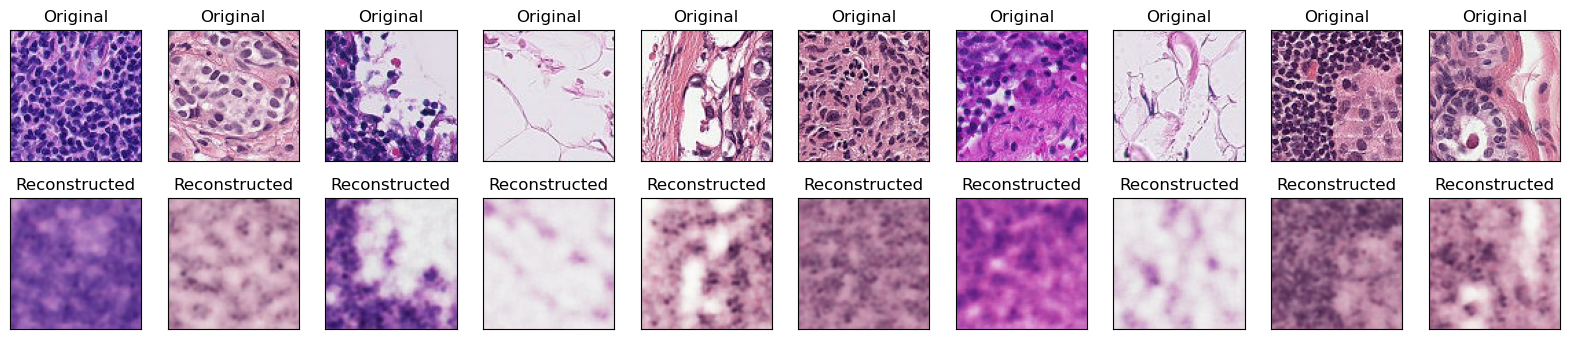

In [12]:
import matplotlib.pyplot as plt

def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i])
        plt.title("Original")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i])
        plt.title("Reconstructed")
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

# Take a batch of images from the test dataset
for test_images, _ in test_dataset.take(1):
    break

# Generate reconstructed images
reconstructed_images = vae_base.predict(test_images)

# Display the first 10 images and their reconstructions
plot_images(test_images, reconstructed_images, n=10)


In [ ]:
epochs = 10  # You can adjust the number of epochs based on your requirements
history = vae.fit(train_dataset,
                  epochs=epochs,
                  validation_data=validation_dataset)

# Optionally, evaluate the model on the test set
test_loss = vae.evaluate(test_dataset)
print("Test loss:", test_loss)